# Continuous Control - PPO

---
This notebook trains the ML-Agents environment [Reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) environment using  Proximal Policy Optimization.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
import numpy as np
import time

To start the environment, **_before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examining the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


When finished, you can close the environment.

### 4. Training the agent using PPO

The implementation of Proximal Policity Optimization agent user here is found at https://github.com/ShangtongZhang/DeepRL. A custom run_steps function is defined to store the last 100 scores and print its mean. ReacherTask class interfaces the UnityAgents environment with DeepRL library.

In [10]:
from deep_rl import *

def run_steps_custom(agent, target_score):
    random_seed()
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    rewards_deque = deque(maxlen=100) # deque to store the mean score of the 20 agents for the last 100 episodes
    rewards_all   = []                # deque to store all scores
    while True:
        rewards = agent.episode_rewards
        if len(rewards):
            rewards_deque.append(np.mean(rewards))
            rewards_all.append(np.mean(rewards))
        if config.log_interval and not agent.total_steps % config.log_interval and len(agent.episode_rewards):
            config.logger.info('Episode %d: %.2f/%.2f/%.2f/%.2f (mean/median/min/max). Mean score %.2f last %d episodes' % (
                len(rewards_all), np.mean(rewards), np.median(rewards), np.min(rewards), np.max(rewards),  np.mean(rewards_deque), len(rewards_deque)))
            agent.episode_rewards = []
            t0 = time.time()
        if len(rewards) and (np.mean(rewards_deque) >= target_score):
            agent.save('./data/model-%s-%s-%s.bin' % (agent_name, config.task_name, config.tag))
            res = True, rewards_deque, rewards_all
            agent.close()
            return res
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            agent.close()
            return False, None, None
            break
        agent.step()
        
        
class ReacherTask(BaseTask):
    def __init__(self):
        BaseTask.__init__(self)
        self.name = 'Reacher'
        self.env = env
        self.action_dim = brain.vector_action_space_size
        self.state_dim = brain.vector_observation_space_size
        
    def reset(self):
        env_info = self.env.reset(train_mode=True)[brain_name]
        return np.array(env_info.vector_observations)

    def step(self, action):
        action = np.clip(action, -1, 1)
        env_info = self.env.step(action)[brain_name]
        next_state = env_info.vector_observations   # next state
        reward = env_info.rewards                   # reward
        done = env_info.local_done
        if np.any(done):
            next_state = self.reset()
        return np.array(next_state), np.array(reward), np.array(done), None
    
    def seed(self, random_seed):
        pass
    
def ppo_continuous():
    config = Config()
    config.num_workers = num_agents
    task_fn = lambda : ReacherTask()
    config.task_fn = task_fn
    config.eval_env = task_fn()

    config.network_fn = lambda: GaussianActorCriticNet(
        config.state_dim, config.action_dim, actor_body=FCBody(config.state_dim),
        critic_body=FCBody(config.state_dim))
    config.optimizer_fn = lambda params: torch.optim.Adam(params, 3e-4, eps=1e-5)
    config.discount = 0.99
    config.use_gae = True
    config.gae_tau = 0.95
    config.gradient_clip = 5
    config.rollout_length = 2048
    config.optimization_epochs = 10
    config.num_mini_batches = 32
    config.ppo_ratio_clip = 0.2
    config.log_interval = 2048
    config.max_steps = 2e7
    config.logger = get_logger()
    return run_steps_custom(PPOAgent(config), 30.0)
    
success, rewards_deque, rewards_all = ppo_continuous()


INFO:MAIN:Episode 1: 0.22/0.00/0.00/1.03 (mean/median/min/max). Mean score 0.22 last 1 episodes
INFO:MAIN:Episode 2: 0.21/0.00/0.00/1.48 (mean/median/min/max). Mean score 0.21 last 2 episodes
INFO:MAIN:Episode 3: 0.12/0.00/0.00/0.63 (mean/median/min/max). Mean score 0.18 last 3 episodes
INFO:MAIN:Episode 4: 0.29/0.20/0.00/0.91 (mean/median/min/max). Mean score 0.21 last 4 episodes
INFO:MAIN:Episode 5: 0.49/0.43/0.00/1.36 (mean/median/min/max). Mean score 0.26 last 5 episodes
INFO:MAIN:Episode 6: 0.78/0.70/0.00/2.37 (mean/median/min/max). Mean score 0.35 last 6 episodes
INFO:MAIN:Episode 7: 1.06/0.96/0.13/2.22 (mean/median/min/max). Mean score 0.45 last 7 episodes
INFO:MAIN:Episode 8: 1.13/1.11/0.00/2.67 (mean/median/min/max). Mean score 0.54 last 8 episodes
INFO:MAIN:Episode 9: 1.64/1.56/0.00/4.05 (mean/median/min/max). Mean score 0.66 last 9 episodes
INFO:MAIN:Episode 10: 1.52/1.50/0.00/3.28 (mean/median/min/max). Mean score 0.74 last 10 episodes
INFO:MAIN:Episode 11: 1.78/1.80/0.00/3

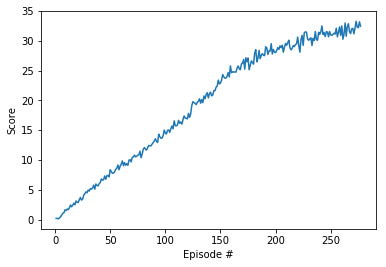

In [11]:
if success:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(rewards_all)+1), rewards_all)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [ ]:
env.close()